# Importing Necessary Libraries and Defining Variables

In [2]:
import tensorflow as tf
import os
import glob
import random

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers

2025-08-10 07:10:50.819904: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-10 07:10:50.895526: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 256, 256, 1
AUTOTUNE = tf.data.AUTOTUNE
T1_DIR = 'TrainT1'
T2_DIR = 'TrainT2'
BATCH_SIZE = 1
TEST_SPLIT = 0.1
lambda_cycle = 10
lambda_identity = 0.5
lambda_perceptual = 0.01

# Read Files and Create Dataset

In [4]:
t1_files = sorted([os.path.join(T1_DIR, f) for f in os.listdir(T1_DIR) if f.endswith('.png')])
t2_files = sorted([os.path.join(T2_DIR, f) for f in os.listdir(T2_DIR) if f.endswith('.png')])

In [5]:
t1_train_files, t1_test_files = train_test_split(t1_files, test_size=TEST_SPLIT, random_state=100)
t2_train_files, t2_test_files = train_test_split(t2_files, test_size=TEST_SPLIT, random_state=100)

In [12]:
def load_png_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = (image / 127.5) - 1  
    return image

In [18]:
def create_dataset(file_list):
    dataset = tf.data.Dataset.from_tensor_slices(file_list)
    dataset = dataset.map(load_png_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

In [19]:
trainA = create_dataset(t1_train_files)
trainB = create_dataset(t2_train_files)

testA = create_dataset(t1_test_files)
testB = create_dataset(t2_test_files)

# Visualize Data

In [20]:
def denormalize(image):
    return (image + 1.0) / 2.0

In [21]:
def show_sample(dataset, title='Sample', num_images=5):
    batch = next(iter(dataset))
    plt.figure(figsize=(num_images * 2, 2))
    
    for i in range(min(num_images, batch.shape[0])):
        plt.subplot(1, num_images, i+1)
        plt.imshow(tf.squeeze(denormalize(batch[i])), cmap='gray')
        plt.axis('off')
        
    plt.suptitle(title, fontsize=14)
    plt.show()

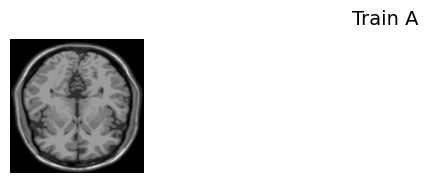

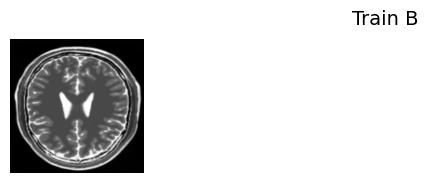

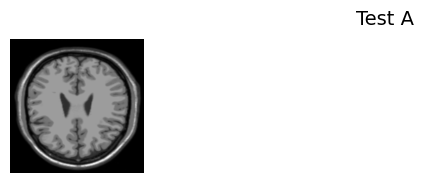

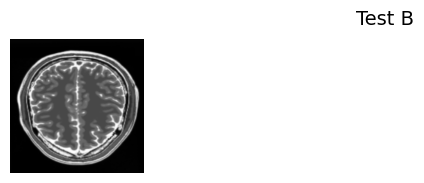

In [22]:
show_sample(trainA, 'Train A')
show_sample(trainB, 'Train B')

show_sample(testA, 'Test A')
show_sample(testB, 'Test B')

# Important Functions

In [23]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                            kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    
    return result

In [25]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                     kernel_initializer=initializer, use_bias=False))
    result.add(layers.BatchNormalization())
    
    if apply_dropout:
        result.add(layers.Dropout(0.5))
        
    result.add(layers.ReLU())
    
    return result

In [26]:
def residual_block(filters, size=3):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    def block(x_input):
        x = layers.Conv2D(filters, size, padding='same', kernel_initializer=initializer,
                         use_bias=False)(x_input)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        
        x = layers.Conv2D(filters, size, padding='same', kernel_initializer=initializer, 
                          use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        
        return layers.add([x_input, x])
    
    return block

In [29]:
def build_vgg19_feature_extractor(layer_name='block3_conv3'):
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
    vgg.trainable = False
    model = Model(inputs=vgg.input, outputs=vgg.get_layer(layer_name).output)
    return model

## Generator Block

In [27]:
def build_generator(image_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_res_blocks=0):
    
    inputs = layers.Input(shape=image_shape)
    
    x = layers.Conv2D(64, kernel_size=7, strides=1, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = downsample(128, 3)(x)
    x = downsample(256, 3)(x)
    
    for _ in range(num_res_blocks):
        x = residual_block(256)(x)
        
    x = upsample(128, 3)(x)
    x = upsample(64, 3)(x)
    
    x = layers.Conv2D(IMG_CHANNELS, kernel_size=7, strides=1, padding='same')(x)
    x = layers.Activation('tanh')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x, name='Generator')

## Discriminator Block

In [28]:
def build_discriminator(image_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = layers.Input(shape=image_shape, name='input_image')
    
    x = layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer)(inp)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Conv2D(512, 4, strides=1, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    output = layers.Conv2D(1, 4, strides=1, padding='same', kernel_initializer=initializer)(x)
    
    return tf.keras.Model(inputs=inp, outputs=output, name='Discriminator')

# Initializing Generators and Discriminators

In [30]:
G = build_generator(num_res_blocks=6)
F = build_generator(num_res_blocks=6)

D_A = build_discriminator()
D_B = build_discriminator()

# Visualize Sample Translation

In [31]:
sample_A = next(iter(trainA))
fake_B = G(sample_A, training=False)
score_real = D_B(fake_B, training=False)

In [32]:
sample_B = next(iter(trainB))
fake_A = F(sample_B, training=False)
score_real = D_A(fake_A, training=False)

In [33]:
def visualize_translation(input_img, translated_img, title='Translation'):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(denormalize(input_img[0]), cmap='gray')
    plt.title("Input")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(denormalize(translated_img[0]), cmap='gray')
    plt.title("Translated")
    plt.axis('off')
    plt.suptitle(title)
    plt.show()

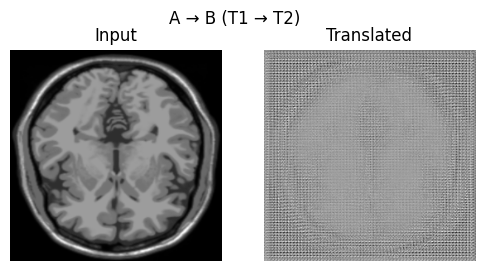

In [34]:
visualize_translation(sample_A, fake_B, title='A → B (T1 → T2)')

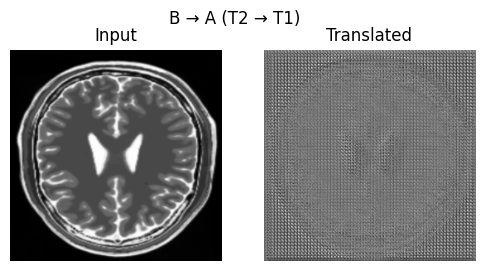

In [35]:
visualize_translation(sample_B, fake_A, title='B → A (T2 → T1)')

# Loss Calculation

In [36]:
loss_obj = tf.keras.losses.MeanSquaredError()

## Generator Loss

In [37]:
def generator_loss(fake_output):
    return loss_obj(tf.ones_like(fake_output), fake_output)

## Discriminator Loss

In [38]:
def discriminator_loss(real_output, fake_output):
    
    real_labes = tf.ones_like(real_output) * 0.9
    
    real_loss = loss_obj(real_labes, real_output)
    fake_loss = loss_obj(tf.zeros_like(fake_output), fake_output)
    
    return (real_loss + fake_loss) * 0.5

## Cycle Loss